In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_helm.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(os.path.join(repo_root, lang_path))
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=os.path.join(repo_root, model_dir))

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Search is started.
0- time: 0.00, reward: -0.9151666177819657, node: PEPTIDE1{V.K.R.K.H.R.F.F.R.R.K.K.K}$$$$
1- time: 0.49, reward: -0.9248103629924731, node: PEPTIDE1{F.G.G.F.S.A.R.E.K.S.A.E.E.E.K}$$$$
2- time: 0.55, reward: -0.9291043490655808, node: PEPTIDE1{[ac].F.Q.S.A.K.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
3- time: 0.65, reward: -0.9030256446567966, node: PEPTIDE1{R.W.R.W.K.W.K.K.W.R.R.F.G.K.K.R.W.W.F.[am]}$$$$
4- time: 0.75, reward: -0.9117027237171902, node: PEPTIDE1{Y.E.L.L.H.G.A.R.Y.G.N.H.A.G.I.L.T.L.[am]}$$$$
5- time: 0.85, reward: 0.881864620538879, node: PEPTIDE1{G.Q.V.G.R.Q.L.A.I.I.G.D.D.I.N.R}$$$$
6- time: 1.03, reward: -0.9385206469892368, node: PEPTIDE1{F.G.G.F.T.G.A.R.K.S.L.R.K.R.A.N.Q}$$$$
7- time: 1.22, reward: 0.9289696312727495, node: PEPTIDE1{T.D.V.Q.M.A.V.K.K.A}$$$$
8- time: 1.27, reward: -0.9086126776884884, node: PEPTIDE1{T.P.Q.R.A.R.R.R.K.K.R.G}$$$$
9- time: 1.41, reward: -0.5237155603146114, node: PEPTIDE1{L.W.A.V}$$$$
10- time: 1.43, reward: -0.950827520

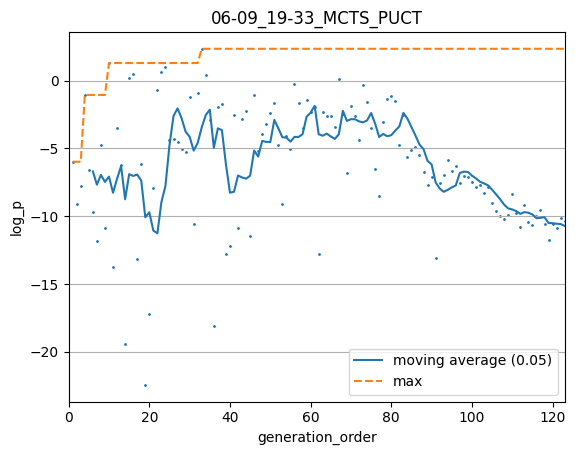

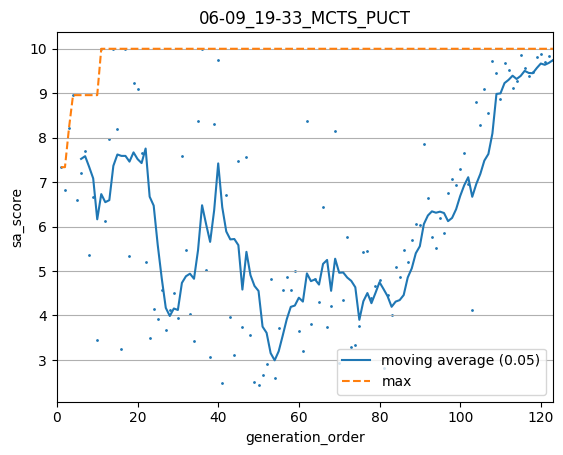

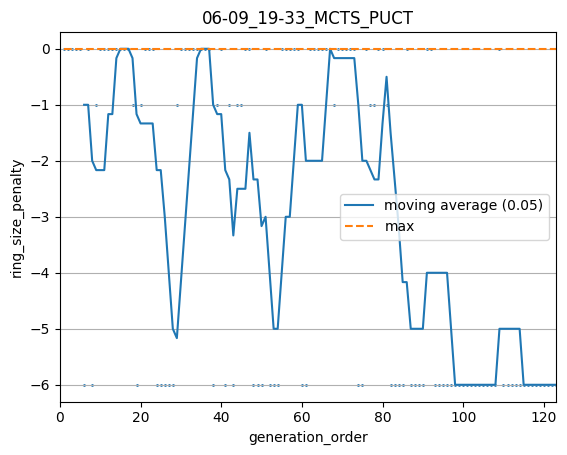

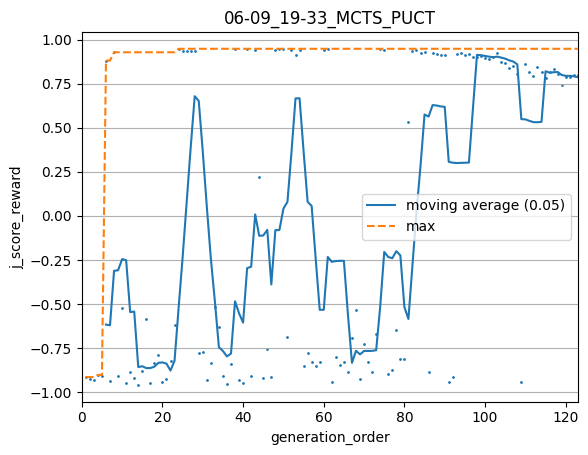

In [3]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

output_dir, generator_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generator_conf", "filtered_reward"))
generator = MCTS(root=root, transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir, **generator_conf)
src = os.path.join(repo_root, config_path)
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

time_limit, max_generations = (conf.get(k) for k in ("time_limit", "max_generations"))
generator.generate(time_limit=time_limit, max_generations=max_generations)
# cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
# generator.plot_objective_values_and_reward(x_axis = "time")

In [12]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [13]:
#load mcts
generator = MCTS.load(save_path, model)